In [17]:
!pip install imutils

In [18]:
# Importing Packages

from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.layers import Dense, Flatten, MaxPooling2D, Input, Dropout, Activation, AveragePooling2D
from tensorflow.keras.applications import VGG16
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.models import Model, Sequential
from keras.callbacks import ReduceLROnPlateau, LearningRateScheduler
from sklearn.metrics import classification_report
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelBinarizer
from sklearn.preprocessing import LabelEncoder
from tensorflow.keras.callbacks import EarlyStopping

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import matplotlib.pyplot as plt
import seaborn as sns
import os
import random
import shutil
import cv2
from imutils import paths



In [19]:
# root path 
dataset_path = './dataset'

In [20]:
# Make directories for storing images

%%bash
rm -rf dataset
mkdir -p dataset/covid
mkdir -p dataset/normal
mkdir -p dataset/pneumonia
mkdir -p dataset/tuberculosis

In [21]:
# Set sample size 
samples = 25
covid_dataset_path = '../input/covid-chest-xray'

AxesSubplot(0.125,0.125;0.775x0.755)


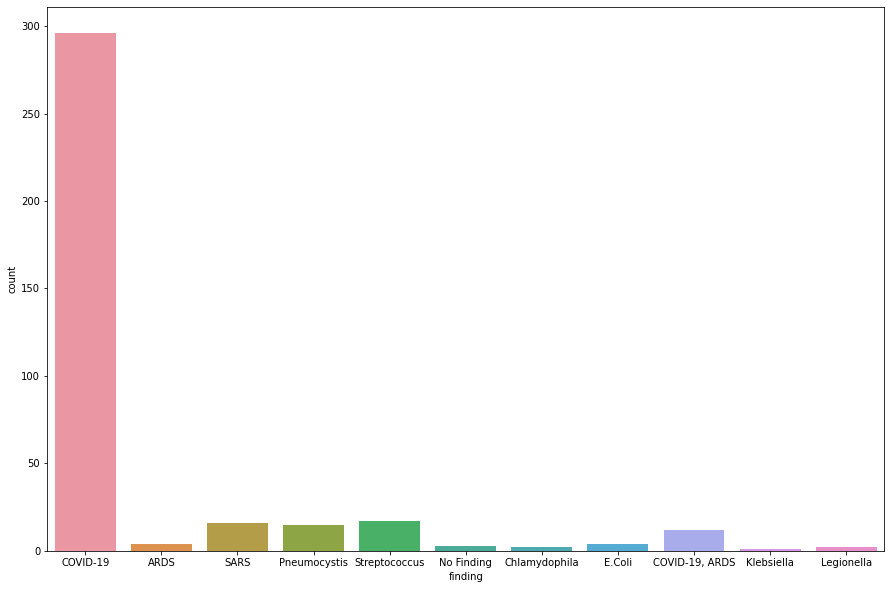

In [22]:
# Exploring both the datasets

# construct thvalue_counts the metadata CSV file and load it
csvPath = os.path.sep.join([covid_dataset_path, "metadata.csv"])
df = pd.read_csv(csvPath)

#EDA for COVID Xray Dataset
plt.figure(figsize=(15,10))
print(sns.countplot(x = df["finding"]))


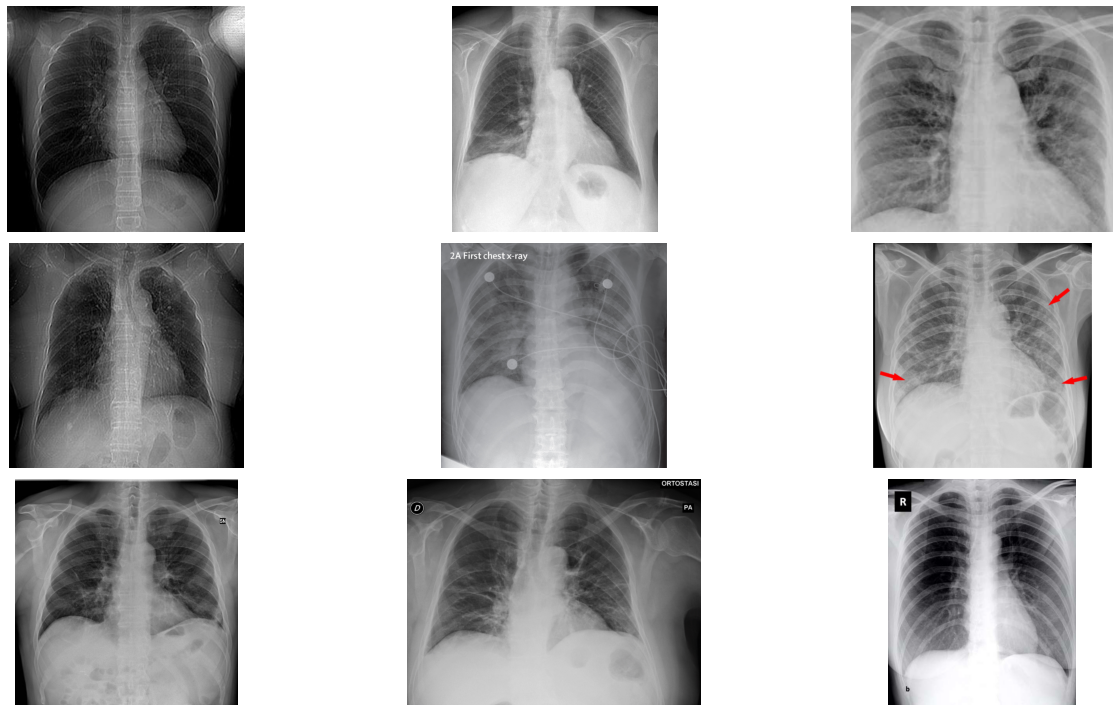

In [23]:
# Transfering the COVID-19 images to the COVID folder 

# loop over the rows of the COVID-19 data frame
for (i, row) in df.iterrows():
    # if (1) the current case is not COVID-19 or (2) this is not
    # a 'PA' view, then ignore the row
    if row["finding"] != "COVID-19" or row["view"] != "PA":
        continue

    # build the path to the input image file
    imagePath = os.path.sep.join([covid_dataset_path, "images", row["filename"]])

    # if the input image file does not exist (there are some errors in
    # the COVID-19 metadeta file), ignore the row
    if not os.path.exists(imagePath):
        continue

    # extract the filename from the image path and then construct the
    # path to the copied image file
    filename = row["filename"].split(os.path.sep)[-1]
    outputPath = os.path.sep.join([f"{dataset_path}/covid", filename])

    # copy the image
    shutil.copy2(imagePath, outputPath)

# Display the images     
    
covid = os.listdir("./dataset/covid")
covid_dir = "./dataset/covid"
plt.figure(figsize=(20, 10))

for i in range(9):
    plt.subplot(3, 3, i + 1)
    img = plt.imread(os.path.join(covid_dir, covid[i]))
    plt.imshow(img, cmap='gray')
    plt.axis('off')
    
plt.tight_layout()
    

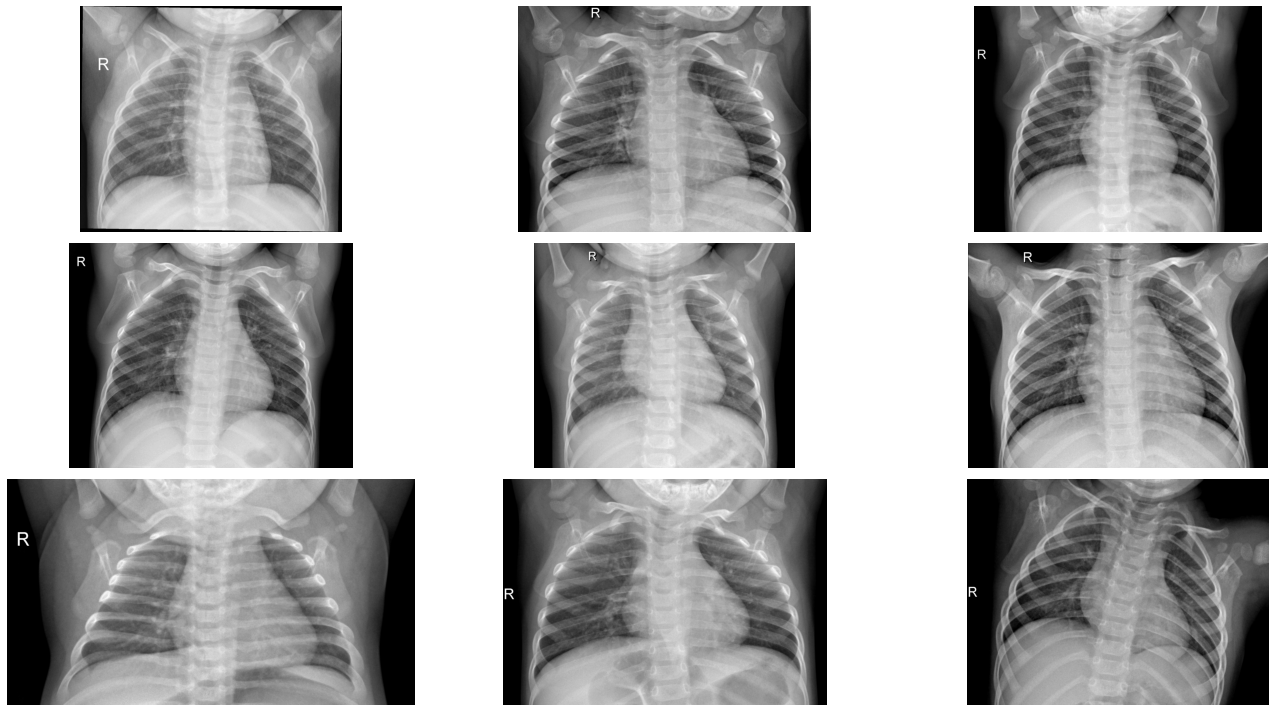

In [24]:
# Transfering the normal images to the normal folder 

normal_dataset_path = '../input/chest-xray-pneumonia/chest_xray' 

basePath = os.path.sep.join([normal_dataset_path, "train", "NORMAL"])
ImagePaths = list(paths.list_images(basePath))

random.seed(42)
random.shuffle(ImagePaths)
ImagePaths = ImagePaths[:samples]


for (i, ImagePath) in enumerate(ImagePaths):
    filename = ImagePath.split(os.path.sep)[-1]
    outputPath = os.path.sep.join([f"{dataset_path}/normal", filename])
    
    shutil.copy2(ImagePath, outputPath)

# Display the images 
    
normal = os.listdir("./dataset/normal")
normal_dir = "./dataset/normal"
plt.figure(figsize=(20, 10))

for i in range(9):
    plt.subplot(3, 3, i + 1)
    img = plt.imread(os.path.join(normal_dir, normal[i]))
    plt.imshow(img, cmap='gray')
    plt.axis('off')
    
plt.tight_layout()

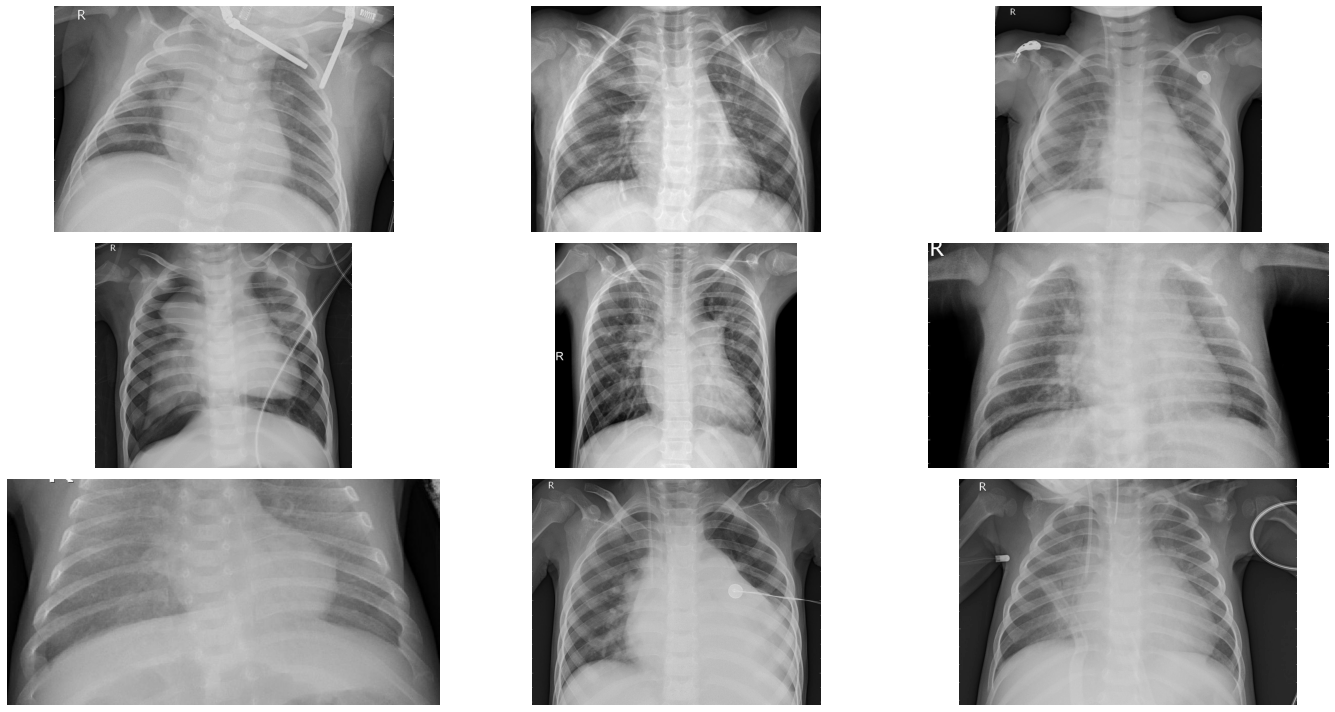

In [25]:
# Transfering the pneumonia images to the pneumonia folder 

pneumonia_dataset_path = '../input/chest-xray-pneumonia/chest_xray' 

PneuPath = os.path.sep.join([pneumonia_dataset_path, "train", "PNEUMONIA"])
ImagePaths = list(paths.list_images(PneuPath))

random.seed(42)
random.shuffle(ImagePaths)
ImagePaths = ImagePaths[:samples]


for (i, ImagePath) in enumerate(ImagePaths):
    filename = ImagePath.split(os.path.sep)[-1]
    outputPath = os.path.sep.join([f"{dataset_path}/pneumonia", filename])
    
    shutil.copy2(ImagePath, outputPath)
    
# Display the images       
    
pneumonia = os.listdir("./dataset/pneumonia")
pneumonia_dir = "./dataset/pneumonia"
plt.figure(figsize=(20, 10))

for i in range(9):
    plt.subplot(3, 3, i + 1)
    img = plt.imread(os.path.join(pneumonia_dir, pneumonia[i]))
    plt.imshow(img, cmap='gray')
    plt.axis('off')
    
plt.tight_layout()   

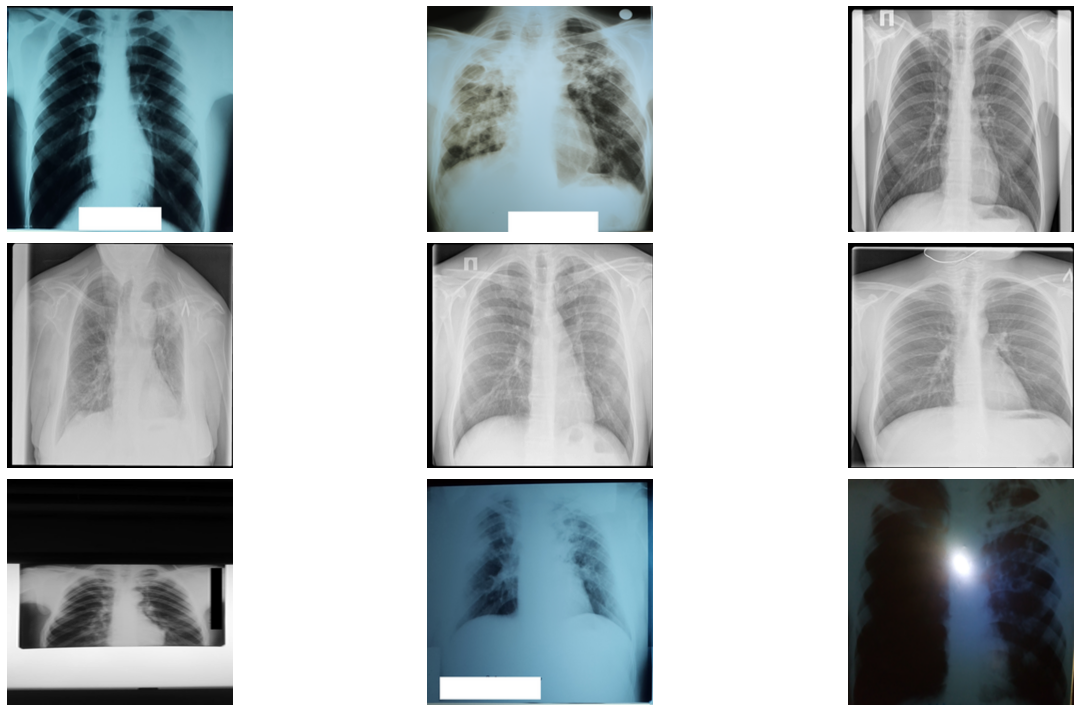

In [26]:
# Transfering the tuberculosis images to the tuberculosis folder 

tuberculosis_dataset_path = '../input/chest-xray-pneumoniacovid19tuberculosis'

TubePath = os.path.sep.join([tuberculosis_dataset_path,"train","TURBERCULOSIS"])
ImagePaths = list(paths.list_images(TubePath))

random.seed(42)
random.shuffle(ImagePaths)
ImagePaths = ImagePaths[:samples]


for (i, ImagePath) in enumerate(ImagePaths):
    filename = ImagePath.split(os.path.sep)[-1]
    outputPath = os.path.sep.join([f"{dataset_path}/tuberculosis", filename])
    
    shutil.copy2(ImagePath, outputPath)
    
# Display the images     
    
tuberculosis = os.listdir("./dataset/tuberculosis")
tuberculosis_dir = "./dataset/tuberculosis"
plt.figure(figsize=(20, 10))

for i in range(9):
    plt.subplot(3, 3, i + 1)
    img = plt.imread(os.path.join(tuberculosis_dir, tuberculosis[i]))
    plt.imshow(img, cmap='gray')
    plt.axis('off')
    
plt.tight_layout()

In [27]:
# Data Preprocessing

# initialize the initial learning rate, number of epochs to train for,
# and batch size
LR = 1e-3
EPOCHS = 30
BS = 8


In [28]:
# Data Preprocessing - Converting the images to grey

imagePaths = list(paths.list_images(dataset_path))

data = []
labels = []


for image in imagePaths:
    label = image.split(os.path.sep)[-2]
    img = cv2.imread(image)
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    img = cv2.resize(img,(224,224))
    
    
    data.append(img)
    labels.append(label)
    
data = np.array(data) / 255.0
labels = np.array(labels)
    

In [29]:
# One hot encoding for labels

lb = LabelEncoder()


labels = lb.fit_transform(labels)
labels = to_categorical(labels)

X_train, X_test, y_train, y_test = train_test_split(data, labels, test_size=0.20, random_state=42, stratify=labels)

trainAug = ImageDataGenerator(rotation_range=15, fill_mode="nearest")

In [30]:
# Creating the CNN

baseModel = VGG16(weights="imagenet", include_top=False, input_tensor=Input(shape=(224, 224, 3)))

mainModel = baseModel.output
mainModel = AveragePooling2D(pool_size = (4,4))(mainModel)
mainModel = Flatten(name = "flatten")(mainModel)
mainModel = Dense(64, activation = "relu")(mainModel)
mainModel = Dropout(0.5)(mainModel)
mainModel = Dense(4, activation = "softmax")(mainModel)

model = Model(inputs = baseModel.input, outputs = mainModel)


for layer in baseModel.layers:
    layer.trainable = False
    
opt = Adam(learning_rate=LR)

model.compile(loss= "categorical_crossentropy", optimizer = "adam", metrics = ["accuracy"])    

In [31]:
# Setup the callbacks

early_stop = EarlyStopping(monitor='val_loss', patience=2, restore_best_weights=True)


In [32]:
# Fit the data to the model

H = model.fit_generator(
    trainAug.flow(X_train, y_train, batch_size=BS),
    steps_per_epoch= len(X_train) // BS,
    validation_data= (X_test, y_test),
    validation_steps = len(X_test) // BS,
    epochs=EPOCHS, callbacks = early_stop)

/opt/conda/lib/python3.7/site-packages/keras/engine/training.py:1972: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  warnings.warn('`Model.fit_generator` is deprecated and '


Epoch 1/30
21/21 [==============================] - 53s 2s/step - loss: 1.2666 - accuracy: 0.5366 - val_loss: 0.9943 - val_accuracy: 0.6591
Epoch 2/30
21/21 [==============================] - 51s 2s/step - loss: 1.0540 - accuracy: 0.6220 - val_loss: 0.9679 - val_accuracy: 0.6591
Epoch 3/30
21/21 [==============================] - 52s 2s/step - loss: 1.0041 - accuracy: 0.6585 - val_loss: 0.9399 - val_accuracy: 0.6591
Epoch 4/30
21/21 [==============================] - 51s 2s/step - loss: 0.9685 - accuracy: 0.6646 - val_loss: 0.9066 - val_accuracy: 0.6591
Epoch 5/30
21/21 [==============================] - 51s 2s/step - loss: 0.9636 - accuracy: 0.6548 - val_loss: 0.8910 - val_accuracy: 0.6591
Epoch 6/30
21/21 [==============================] - 50s 2s/step - loss: 0.8901 - accuracy: 0.6463 - val_loss: 0.8412 - val_accuracy: 0.6591
Epoch 7/30
21/21 [==============================] - 51s 2s/step - loss: 0.8589 - accuracy: 0.6829 - val_loss: 0.8103 - val_accuracy: 0.6818
Epoch 8/30
21/21 [==

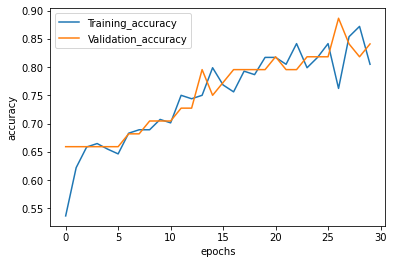

In [33]:
# Plot showing the accuracy across epochs

accs = H.history['accuracy']
val_accs = H.history['val_accuracy']

plt.plot(range(len(accs)),accs, label = 'Training_accuracy')
plt.plot(range(len(accs)),val_accs, label = 'Validation_accuracy')
plt.ylabel('accuracy')
plt.xlabel('epochs')
plt.legend()
plt.show()

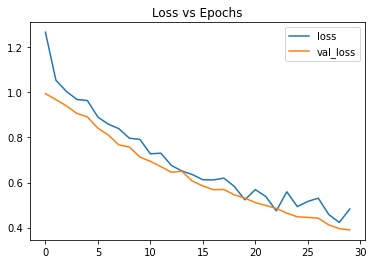

In [34]:
# Plot showing the loss across epochs

pd.DataFrame(model.history.history)[['loss','val_loss']].plot()
plt.title("Loss vs Epochs") 
plt.show()  

In [35]:
# Predictions

preds = model.predict(X_test, batch_size=BS)

preds = np.argmax(preds, axis=1)

print(classification_report(y_test.argmax(axis=1), preds, target_names=lb.classes_))

              precision    recall  f1-score   support

       covid       0.83      1.00      0.91        29
      normal       0.80      0.80      0.80         5
   pneumonia       1.00      0.40      0.57         5
tuberculosis       1.00      0.40      0.57         5

    accuracy                           0.84        44
   macro avg       0.91      0.65      0.71        44
weighted avg       0.86      0.84      0.82        44

